In [1]:
## Preliminary

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV

!pip install mitosheet 
import mitosheet 

!pip install xgboost
import xgboost

%config InlineBackend.figure_format = "svg"

In [3]:
df = pd.read_csv('train.csv')

In [4]:
# Remove irrelevant columns

In [5]:
# Deleted columns property_id
df.drop(['property_id'], axis=1, inplace=True)

# Deleted columns property_name
df.drop(['property_name'], axis=1, inplace=True)

# Deleted columns property_summary
df.drop(['property_summary'], axis=1, inplace=True)

# Deleted columns property_space
df.drop(['property_space'], axis=1, inplace=True)

# Deleted columns property_desc
df.drop(['property_desc'], axis=1, inplace=True)

# Deleted columns property_neighborhood
df.drop(['property_neighborhood'], axis=1, inplace=True)

# Deleted columns property_notes
df.drop(['property_notes'], axis=1, inplace=True)

# Deleted columns property_transit
df.drop(['property_transit'], axis=1, inplace=True)

# Deleted columns property_access
df.drop(['property_access'], axis=1, inplace=True)

# Deleted columns property_interaction
df.drop(['property_interaction'], axis=1, inplace=True)

# Deleted columns property_rules
df.drop(['property_rules'], axis=1, inplace=True)

# Deleted columns property_sqfeet
df.drop(['property_sqfeet'], axis=1, inplace=True)

# Deleted columns property_scraped_at
df.drop(['property_scraped_at'], axis=1, inplace=True)

# Deleted columns property_last_updated
df.drop(['property_last_updated'], axis=1, inplace=True)

# Deleted columns host_id
df.drop(['host_id'], axis=1, inplace=True)

# Deleted columns host_location
df.drop(['host_location'], axis=1, inplace=True)

# Deleted columns host_about
df.drop(['host_about'], axis=1, inplace=True)

# Deleted columns host_nr_listings_total
df.drop(['host_nr_listings_total'], axis=1, inplace=True)

# Deleted columns host_verified
df.drop(['host_verified'], axis=1, inplace=True)

# Deleted columns booking_max_nights
df.drop(['booking_max_nights'], axis=1, inplace=True)

# Deleted columns reviews_first
df.drop(['reviews_first'], axis=1, inplace=True)

# Deleted columns reviews_last
df.drop(['reviews_last'], axis=1, inplace=True)

In [6]:
# Transform target to logarithm (target)
df['target'] = np.log(df['target'])

In [7]:
# Remove target outliers
Q1_target = df['target'].quantile(0.25)
Q3_target = df['target'].quantile(0.75)
IQR_target = Q3_target - Q1_target

lower_bound_target = Q1_target - 0.5 * IQR_target
upper_bound_target = Q3_target + 0.5 * IQR_target

df = df[(df['target'] >= lower_bound_target) & (df['target'] <= upper_bound_target)]

NumExpr defaulting to 8 threads.


In [8]:
# Check for missing values
df['extra'].isna().sum()

4

In [9]:
#extra (superhost, profile pic etc.)

#Dummy's are:
    #extra: Instant Bookable
    #extra: Host Is Superhost
    #extra: Host Identity Verified
    #extra: Is Location Exact
    #extra: Host Has Profile Pic

In [10]:
#We first create dummy's out of the feature 'extra'


df['extra'] = df['extra'].fillna('')
extras_list = df['extra'].tolist()
extras_set = set()
for extra_string in extras_list:
    if pd.notnull(extra_string):
        extras = extra_string.split(',')
        for extra in extras:
            stripped_extra = extra.strip()
            if stripped_extra and stripped_extra not in ['Require Guest Phone Verification', 'Require Guest Profile Picture']:
                extras_set.add(stripped_extra)

def new_dum_col_filling(main_col_val, dum_col_name, main_col_name):
    if dum_col_name.replace(main_col_name + ': ', '') in main_col_val:
        return 1
    else:
        return 0
    
def new_set_to_dummies(df, column_name):
    new_all_values_of_sets = extras_set
    new_dummy_columns_name = [column_name + ': ' + dum_col for dum_col in new_all_values_of_sets if dum_col]
    new_dummy_df = pd.DataFrame(0, index=df.index, columns=new_dummy_columns_name)
    for dum_col_name in new_dummy_columns_name:
        for i in df.index:
            new_dummy_df[dum_col_name][i] = new_dum_col_filling(df[column_name][i], dum_col_name, column_name)
    df = pd.concat([df, new_dummy_df], axis=1)
    return df
    
df = new_set_to_dummies(df, 'extra')
    
df = df.drop(['extra'],axis=1)


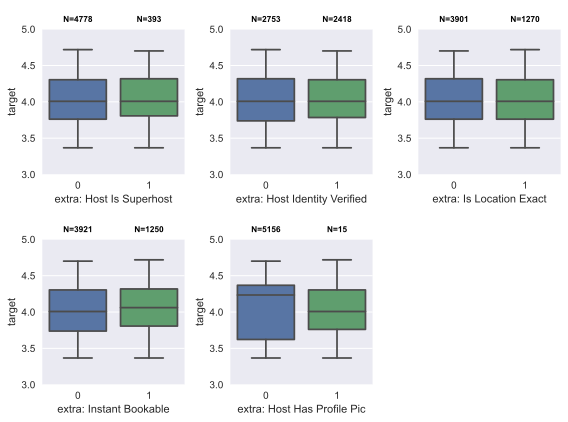

In [11]:
# Define a function to add count labels to boxplot
def add_count_labels(plot, df, column):
    # Get counts per category
    counts = df[column].value_counts()
    # Get y limit of plot
    y_limit = plot.get_ylim()[1]
    # Add count labels to plot
    for i, v in enumerate(counts.values):
        plot.text(i, y_limit*1.02, f'\nN={v}', horizontalalignment='center', size='small', color='black', weight='semibold')

# Create subplots
f, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.4) # adjust space between subplots

# Create boxplots and add count labels
ax1 = plt.subplot(2, 3, 1)
sns.boxplot(data=df, y='target', x='extra: Host Is Superhost')
plt.ylim(3, 5)
add_count_labels(ax1, df, 'extra: Host Is Superhost')

ax2 = plt.subplot(2, 3, 2)
sns.boxplot(data=df, y='target', x='extra: Host Identity Verified')
plt.ylim(3, 5)
add_count_labels(ax2, df, 'extra: Host Identity Verified')

ax3 = plt.subplot(2, 3, 3)
sns.boxplot(data=df, y='target', x='extra: Is Location Exact')
plt.ylim(3, 5)
add_count_labels(ax3, df, 'extra: Is Location Exact')

ax4 = plt.subplot(2, 3, 4)
sns.boxplot(data=df, y='target', x='extra: Instant Bookable')
plt.ylim(3, 5)
add_count_labels(ax4, df, 'extra: Instant Bookable')

ax5 = plt.subplot(2, 3, 5)
sns.boxplot(data=df, y='target', x='extra: Host Has Profile Pic')
plt.ylim(3, 5)
add_count_labels(ax5, df, 'extra: Host Has Profile Pic')

plt.tight_layout() # avoid overlap of plots
plt.draw()


In [12]:
# Secondly, we test whether the feature 'Instant Bookable' has a significant impact on the target, as well as some interactions.
# We are aware that we ignore the NAs since there are only 3

In [13]:
mean1=df.loc[df['extra: Instant Bookable'] == 1]['target'].mean()
mean2=df.loc[df['extra: Instant Bookable'] == 0]['target'].mean()
print("Mean target value for extra: Instant Bookable = 1: {:.2f}".format(mean1))
print("Mean target value for extra: Instant Bookable = 0: {:.2f}".format(mean2))

Mean target value for extra: Instant Bookable = 1: 4.04
Mean target value for extra: Instant Bookable = 0: 4.01


In [14]:
# Calculate mean target and count for each group defined by two columns
df.groupby(['extra: Host Is Superhost', 'extra: Host Identity Verified'])['target'].agg(['mean', 'count']).reset_index()

# Calculate mean target and count for each group defined by three columns
df.groupby(['extra: Host Is Superhost', 'extra: Host Identity Verified', 'extra: Is Location Exact'])['target'].agg(['mean', 'count']).reset_index()

# Calculate mean target and count for each group defined by four columns
df.groupby(['extra: Host Is Superhost', 'extra: Host Identity Verified', 'extra: Is Location Exact', 'extra: Instant Bookable'])['target'].agg(['mean', 'count']).reset_index()

# Calculate mean target and count for each group defined by five columns
df.groupby(['extra: Host Is Superhost', 'extra: Host Identity Verified', 'extra: Is Location Exact', 'extra: Instant Bookable', 'extra: Host Has Profile Pic'])['target'].agg(['mean', 'count']).reset_index()


,extra: Host Is Superhost,extra: Host Identity Verified,extra: Is Location Exact,extra: Instant Bookable,extra: Host Has Profile Pic,mean,count
0,0,0,0,0,0,4.001288,4
1,0,0,0,0,1,4.015501,448
2,0,0,0,1,0,3.730820,2
3,0,0,0,1,1,4.038958,128
4,0,0,1,0,0,3.978371,5
5,0,0,1,0,1,4.006867,1221
6,0,0,1,1,0,4.415446,4
7,0,0,1,1,1,4.054051,484
8,0,1,0,0,1,4.030041,478
9,0,1,0,1,1,3.984758,125


In [15]:
df['extra: Instant Bookable'].dropna().unique()

array([0, 1], dtype=int64)

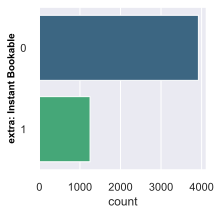

In [16]:
sns.set(style='darkgrid')
plt.figure(figsize=(3,3))
sns.countplot(y = df['extra: Instant Bookable'],order = df['extra: Instant Bookable'].value_counts().index,palette = "viridis")
plt.ylabel('extra: Instant Bookable',fontsize = 10, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

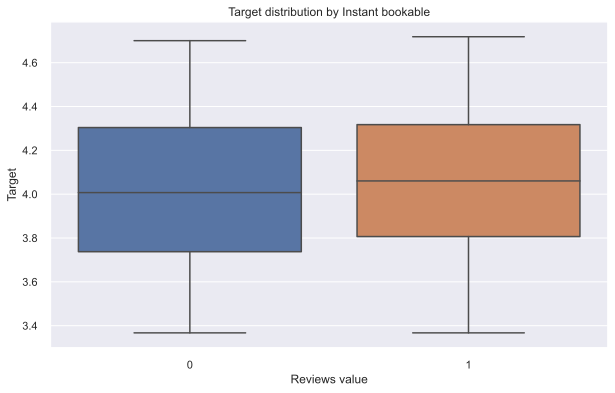

In [17]:
# Generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='extra: Instant Bookable', y='target', data=df)
ax.set_title('Target distribution by Instant bookable')
ax.set_xlabel('Reviews value')
ax.set_ylabel('Target')
plt.show()

In [18]:
# Generate the statistical description
df.groupby('extra: Instant Bookable')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
extra: Instant Bookable,,,,,,,,
0,3921.0,4.013731,0.350589,3.367296,3.737670,4.007333,4.304065,4.700480
1,1250.0,4.035770,0.337866,3.367296,3.806662,4.060443,4.317488,4.718499


In [19]:
# Check if there are significant differences in price between the types
from scipy.stats import f_oneway

policy_groups = [group['target'] for name, group in df.groupby('extra: Instant Bookable')]
f_stat, p_value = f_oneway(*policy_groups)

if p_value < 0.05:
    print("There are significant differences in target values between types")
else:
    print("There are no significant differences in target values between types")

There are no significant differences in target values between types


In [20]:
# At first sight, the feature 'extra: Instant Bookable' seemed to have an impact. But our EDA shows it can be dropped.
# Next, we look at the interaction variable

In [21]:
df['int_ProfilePic_Location_InstantBookable'] = df['extra: Host Has Profile Pic'] * df['extra: Is Location Exact'] * df['extra: Instant Bookable']

In [22]:
mean1=df.loc[df['int_ProfilePic_Location_InstantBookable'] == 1]['target'].mean()
mean2=df.loc[df['int_ProfilePic_Location_InstantBookable'] == 0]['target'].mean()
print("Mean target value for extra: int_ProfilePic_Location_InstantBookable = 1: {:.2f}".format(mean1))
print("Mean target value for extra: int_ProfilePic_Location_InstantBookable Bookable = 0: {:.2f}".format(mean2))

Mean target value for extra: int_ProfilePic_Location_InstantBookable = 1: 4.04
Mean target value for extra: int_ProfilePic_Location_InstantBookable Bookable = 0: 4.01


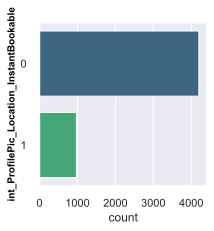

In [23]:
sns.set(style='darkgrid')
plt.figure(figsize=(3,3))
sns.countplot(y = df['int_ProfilePic_Location_InstantBookable'],order = df['int_ProfilePic_Location_InstantBookable'].value_counts().index,palette = "viridis")
plt.ylabel('int_ProfilePic_Location_InstantBookable',fontsize = 10, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

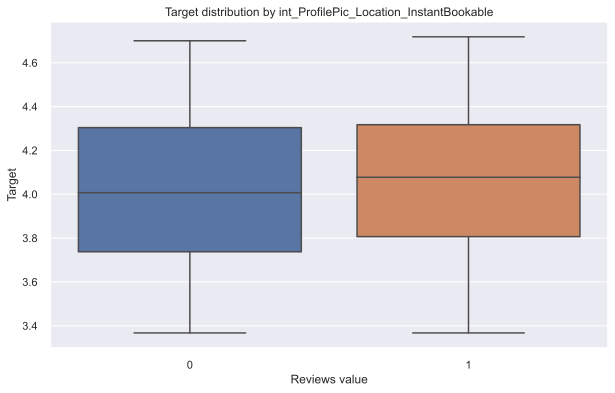

In [24]:
# Generate the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='int_ProfilePic_Location_InstantBookable', y='target', data=df)
ax.set_title('Target distribution by int_ProfilePic_Location_InstantBookable')
ax.set_xlabel('Reviews value')
ax.set_ylabel('Target')
plt.show()

In [25]:
# Generate the statistical description
df.groupby('int_ProfilePic_Location_InstantBookable')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
int_ProfilePic_Location_InstantBookable,,,,,,,,
0,4200.0,4.014177,0.349620,3.367296,3.737670,4.007333,4.304065,4.700480
1,971.0,4.040172,0.338373,3.367296,3.806662,4.077537,4.317488,4.718499


In [26]:
# Check if there are significant differences in price between the types
from scipy.stats import f_oneway

policy_groups = [group['target'] for name, group in df.groupby('int_ProfilePic_Location_InstantBookable')]
f_stat, p_value = f_oneway(*policy_groups)

if p_value < 0.05:
    print("There are significant differences in target values between types")
else:
    print("There are no significant differences in target values between types")

There are significant differences in target values between types


In [27]:
# The interaction term does not have an impact either.

In [28]:
# Because of the reasons highlighted in this EDA, we have decided to remove extra
# as an attribute from our training set.